In [40]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
import pmdarima as pm
import torch

In [41]:
df = pd.read_csv("ILI_estimate.csv")
len(df["Date of Encounter"].unique())

/tmp/ipykernel_6933/244823116.py:1: DtypeWarning: Columns (9,22,28,52,56,60,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ILI_estimate.csv")


442

0       2023-08-27
1       2023-07-04
2       2023-07-01
3       2023-08-31
4       2023-07-28
           ...    
10399   2023-03-14
10400   2022-07-22
10401   2022-08-16
10402   2024-02-12
10403   2023-09-12
Name: Date of Encounter, Length: 10404, dtype: datetime64[ns]

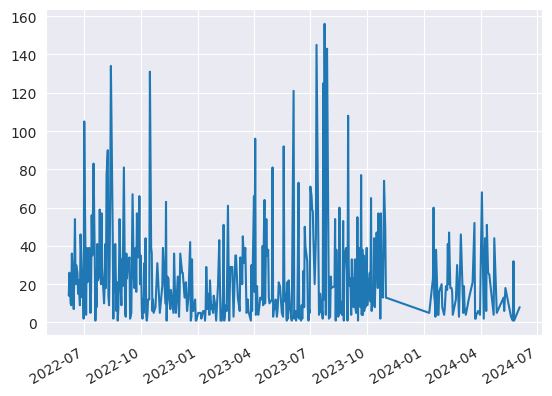

In [42]:
df['Date of Encounter'] = pd.to_datetime(pd.to_datetime(df['Date of Encounter']).apply(lambda x: x.date()))
df['Date of Encounter'].value_counts().sort_index().plot() 
df["Date of Encounter"]

In [43]:
df["start_of_year"] = pd.to_datetime(df["Date of Encounter"].apply(lambda x: pd.Timestamp(year=x.year, month=1, day=1)))
df["days_since_start_of_year"] = (df["Date of Encounter"] - df["start_of_year"]).dt.days
df["days_since_start_of_year"]

0        238
1        184
2        181
3        242
4        208
        ... 
10399     72
10400    202
10401    227
10402     42
10403    254
Name: days_since_start_of_year, Length: 10404, dtype: int64

In [44]:
year = df['Date of Encounter'].dt.isocalendar().year.astype(str)
week = df['Date of Encounter'].dt.isocalendar().week.astype(str)
df['year'] = year
df['week'] = week
df['year-week'] = year + "-" + week

def convert_to_date(year_week):
    year, day = map(int, year_week.split('-'))
    # Convert week to month assuming each month has 4 weeks
    month = (day - 1) // 30 + 1
    return f'{year}-D{day:02d}-MONTH{month:02d}'

In [45]:
baseline_df = df[df['year'].isin(['2021','2022','2023'])]

<Axes: >

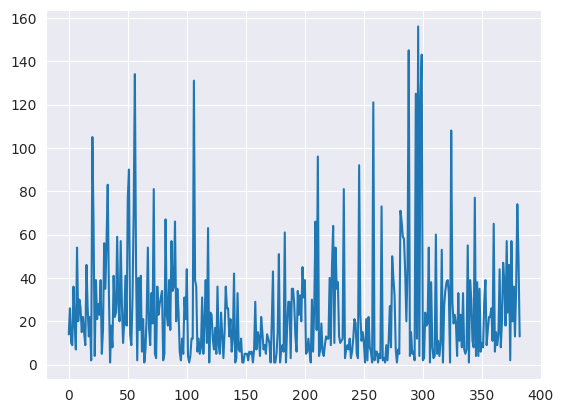

In [46]:
weekly = baseline_df['Date of Encounter'].value_counts().sort_index().reset_index()
weekly.columns = ['Date of Encounter','count']
weekly['count'].plot()

In [47]:
weekly

,Date of Encounter,count
0,2022-06-06,14
1,2022-06-07,26
2,2022-06-09,10
3,2022-06-10,9
4,2022-06-11,36
...,...,...
378,2023-10-26,13
379,2023-10-27,35
380,2023-10-28,74
381,2023-10-30,49


In [48]:
year = weekly['Date of Encounter'].dt.isocalendar().year.astype(str)
day = (df["Date of Encounter"] - df["start_of_year"]).dt.days
weekly['year'] = year
weekly['day'] = day
weekly['year-day'] = year + "-" + day.astype(str)


weekly

,Date of Encounter,count,year,day,year-day
0,2022-06-06,14,2022,238,2022-238
1,2022-06-07,26,2022,184,2022-184
2,2022-06-09,10,2022,181,2022-181
3,2022-06-10,9,2022,242,2022-242
4,2022-06-11,36,2022,208,2022-208
...,...,...,...,...,...
378,2023-10-26,13,2023,293,2023-293
379,2023-10-27,35,2023,300,2023-300
380,2023-10-28,74,2023,10,2023-10
381,2023-10-30,49,2023,170,2023-170


In [49]:
weekly['day'] = weekly['year-day'].apply(convert_to_date)
weekly.set_index('day', inplace=True)

weekly.head()

,Date of Encounter,count,year,year-day
day,,,,
2022-D238-MONTH08,2022-06-06,14,2022,2022-238
2022-D184-MONTH07,2022-06-07,26,2022,2022-184
2022-D181-MONTH07,2022-06-09,10,2022,2022-181
2022-D242-MONTH09,2022-06-10,9,2022,2022-242
2022-D208-MONTH07,2022-06-11,36,2022,2022-208


In [ ]:
model = pm.auto_arima(
    weekly['count'], 
    start_p = 1,
    start_q = 1,
    max_p = 12,
    max_q = 12,
    seasonal = True,
    trace = True,
    m = 365
)

/home/miniloda/.local/lib/python3.10/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (18) is shorter than m (365). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "


Performing stepwise search to minimize aic


AR(2) I(1) MA(1)
[y_(t+1)+y_(t)]/2

In [12]:
def detect_changes(df, threshold, arima_model):
    mean_ = df['count'].mean()
    dev_  = df['count'].std()
    
    df["warning_cusum"] = None
    df["warning_c1"] = None
    df["warning_c2"] = None
    df["warning_arima"] = None

    # Initialize C1 and C2
    df['C1'] = 0.0
    df['C2'] = 0.0

    counter = 0

    for i, row in df.iterrows():
        change_ = max(0, row["count"] - mean_)

        if change_ > threshold * dev_:
            df.at[i,"warning_cusum"] = 1
        else:
            df.at[i,"warning_cusum"] = 0

        # Calculate C1 and C2
        c1 = df.at[prev_idx, 'C1'].values[0] if counter > 0 else 0
        c2 = df.at[prev_idx, 'C2'].values[0] if counter > 0 else 0
                
        df.at[i, 'C1'] = max(0, row["count"] - mean_ + c1)
        df.at[i, 'C2'] = max(0, mean_ - row["count"] + c2)

        # Detect changes for C1 and C2
        df.at[i, 'warning_c1'] = (df.at[i, 'C1'] > threshold * dev_).astype(int)
        df.at[i, 'warning_c2'] = (df.at[i, 'C2'] > threshold * dev_).astype(int)

        prev_idx = i

        counter += 1

    df['predicted'] = arima_model.predict_in_sample()

    df['warning_arima'] = (df['count'] - df['predicted'] > threshold * np.std(df['count'] - df['predicted'])).astype(int)

    return df

In [13]:
weekly

,Date of Encounter,count,year,year-week
week,,,,
2022-W23-MONTH06,2022-06-06,14,2022,2022-23
2022-W23-MONTH06,2022-06-07,26,2022,2022-23
2022-W23-MONTH06,2022-06-09,10,2022,2022-23
2022-W23-MONTH06,2022-06-10,9,2022,2022-23
2022-W23-MONTH06,2022-06-11,36,2022,2022-23
...,...,...,...,...
2023-W43-MONTH11,2023-10-26,13,2023,2023-43
2023-W43-MONTH11,2023-10-27,35,2023,2023-43
2023-W43-MONTH11,2023-10-28,74,2023,2023-43


In [14]:
weekly_ = detect_changes(weekly, threshold = 2, arima_model = model)

In [15]:
weekly_.head()

,Date of Encounter,count,year,year-week,warning_cusum,warning_c1,warning_c2,warning_arima,C1,C2,predicted
week,,,,,,,,,,,
2022-W23-MONTH06,2022-06-06,14,2022,2022-23,0,0,0,0,11.548303,27.258486,24.651467
2022-W23-MONTH06,2022-06-07,26,2022,2022-23,0,0,0,0,11.548303,27.258486,23.908318
2022-W23-MONTH06,2022-06-09,10,2022,2022-23,0,0,0,0,11.548303,27.258486,24.076675
2022-W23-MONTH06,2022-06-10,9,2022,2022-23,0,0,0,0,11.548303,27.258486,23.228903
2022-W23-MONTH06,2022-06-11,36,2022,2022-23,0,0,0,0,11.548303,27.258486,22.447376


In [16]:
weekly_.describe()

,count,warning_arima,C1,C2,predicted
count,383.000000,383.000000,383.000000,383.000000,383.000000
mean,24.451697,0.046997,302.038121,502.176087,24.424119
std,26.034253,0.211910,243.588751,383.260356,4.139140
min,1.000000,0.000000,0.000000,0.000000,16.163424
25%,6.000000,0.000000,36.548303,34.710183,21.820761
50%,16.000000,0.000000,309.224543,620.308094,24.076675
75%,34.500000,0.000000,545.093995,809.976501,26.841767
max,156.000000,1.000000,637.417755,1160.370757,41.866433


In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  383
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1786.282
Date:                Sat, 20 Jul 2024   AIC                           3580.564
Time:                        13:14:59   BIC                           3596.356
Sample:                             0   HQIC                          3586.829
                                - 383                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0451      1.145      0.912      0.362      -1.200       3.290
ar.L1          0.9576      0.046     21.009      0.000       0.868       1.047
ma.L1         -0.9110      0.057    -15.914      0.000      -1.023      -0.799
sigma2       658.1461     38.388     17.145      0.000     582.908     733.385
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               721.40
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                             2.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
def plot_changes(df, warnings):
    plt.figure(figsize=(10, 6))

    plt.plot(df['count'], label='Count')

    colors = {'warning_cusum': 'red', 'warning_c1': 'green', 'warning_c2': 'purple', 'warning_arima': 'blue'}
    labels = {'warning_cusum': 'Change detected by Cumulative Sum Control', 'warning_c1': 'Change detected by C1', 'warning_c2': 'Change detected by C2', 'warning_arima': 'Change detected by ARIMA'}
    markers = {'warning_cusum': 'o', 'warning_c1': 'o', 'warning_c2': 's', 'warning_arima': 'x'}

    for warning in warnings:
        change_points = df[df[warning]==1]
        plt.scatter(change_points.index, change_points['count'], color=colors[warning], label=labels[warning], marker=markers[warning])

    # Set the x-ticks to the weeks where a change was detected by the selected warnings
    change_points_indices = set()
    for warning in warnings:
        change_points_indices = change_points_indices.union(set(df[df[warning]==1].index.values))
    plt.xticks(list(change_points_indices))

    #plt.xticks([])

    # Add labels and title
    plt.xlabel('Week')
    plt.ylabel('Count')
    plt.title('Influenza-Like Illnesses Warning Levels')

    # Add a legend
    plt.legend()

    plt.xticks(rotation=75)

    # Display the plot
    plt.show()

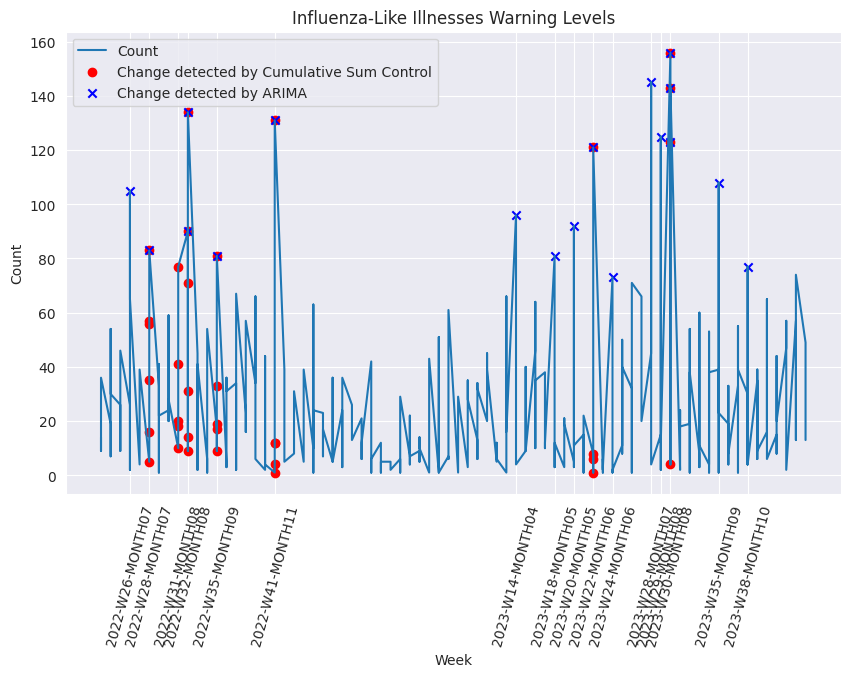

In [19]:
# Use the function
plot_changes(weekly_, ['warning_cusum', 'warning_arima'])